In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/breast-cancer-diagnostic.shuf.lrn.csv')
df.head(2)

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,8813129,False,13.27,17.02,84.55,546.4,0.08445,0.04994,0.03554,0.024560,...,15.14,23.60,98.84,708.8,0.1276,0.1311,0.17860,0.09678,0.2506,0.07623
1,898678,False,12.06,18.90,76.66,445.3,0.08386,0.05794,0.00751,0.008488,...,13.64,27.06,86.54,562.6,0.1289,0.1352,0.04506,0.05093,0.2880,0.08083


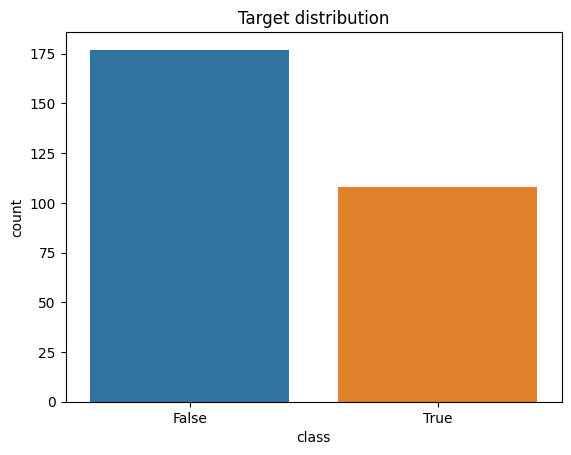

In [ ]:
sns.countplot(data=df, x='class')
plt.title('Target distribution')
plt.show()

In [ ]:
#number of NaN values in the df
df.isna().sum().sum()

0

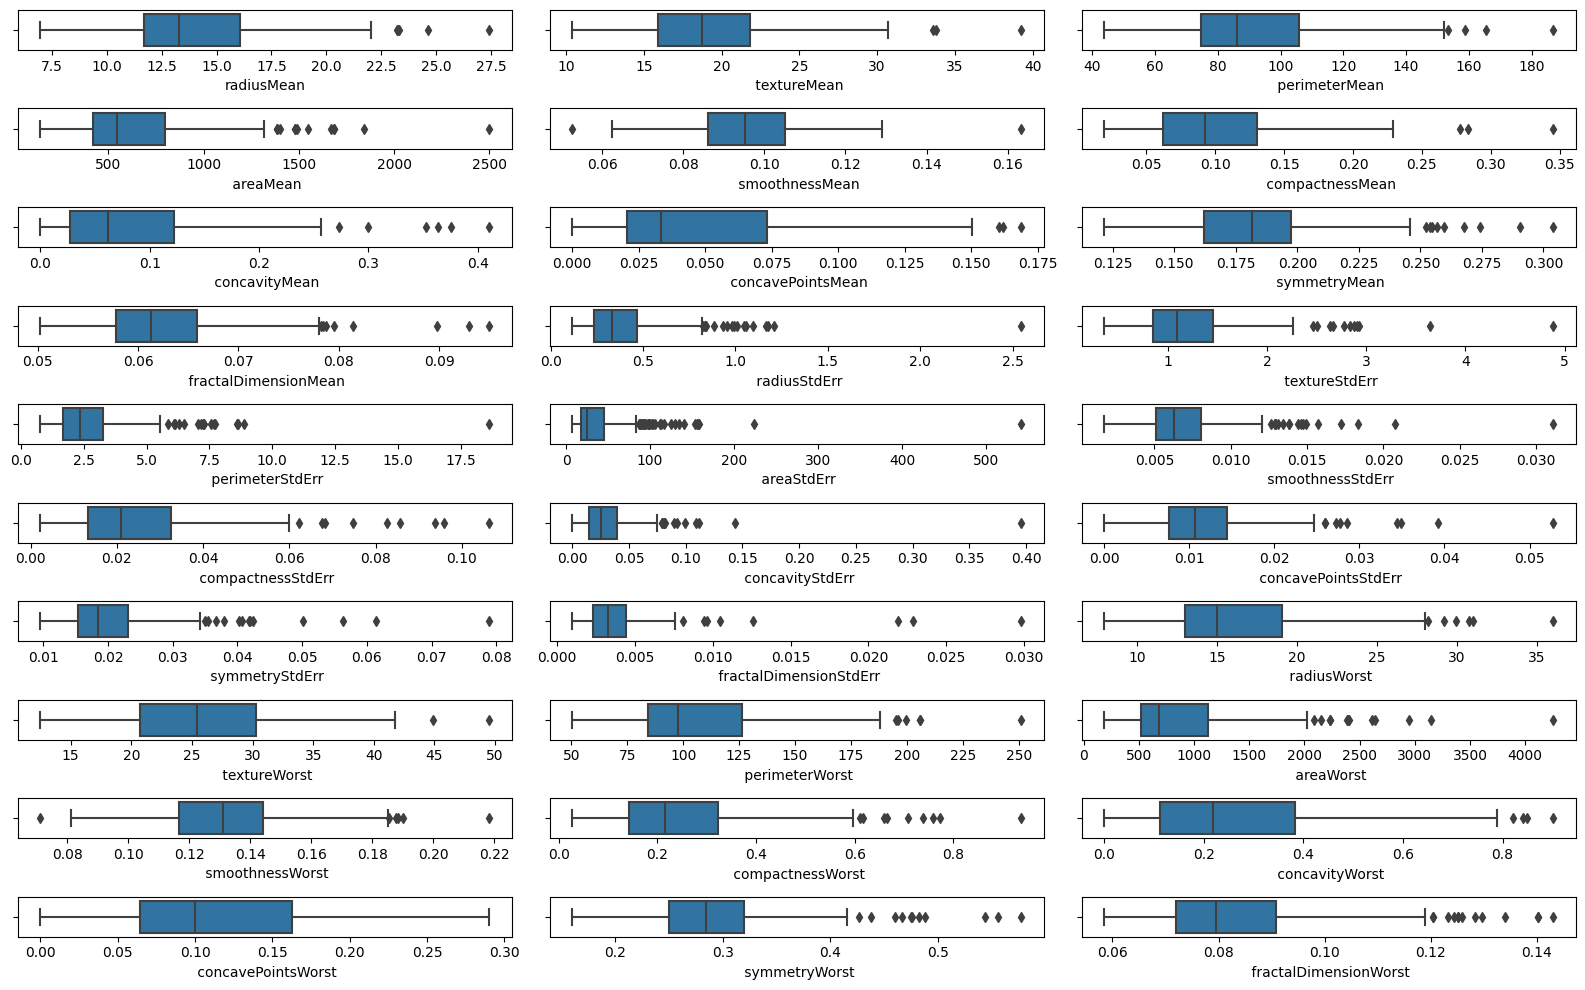

In [ ]:
#looking for outliers
def plot_features():
  fig, axs = plt.subplots(figsize=(16, 10), ncols=3, nrows=10)
  for count, col in enumerate(df.columns[2:]):

    sns.boxplot(data=df, x=col, ax=axs[count // 3][count % 3])
  plt.tight_layout()
  plt.show()
plot_features()

Data need to be scaled, because some features are in value range between 0 and 1 and other between 0-4000

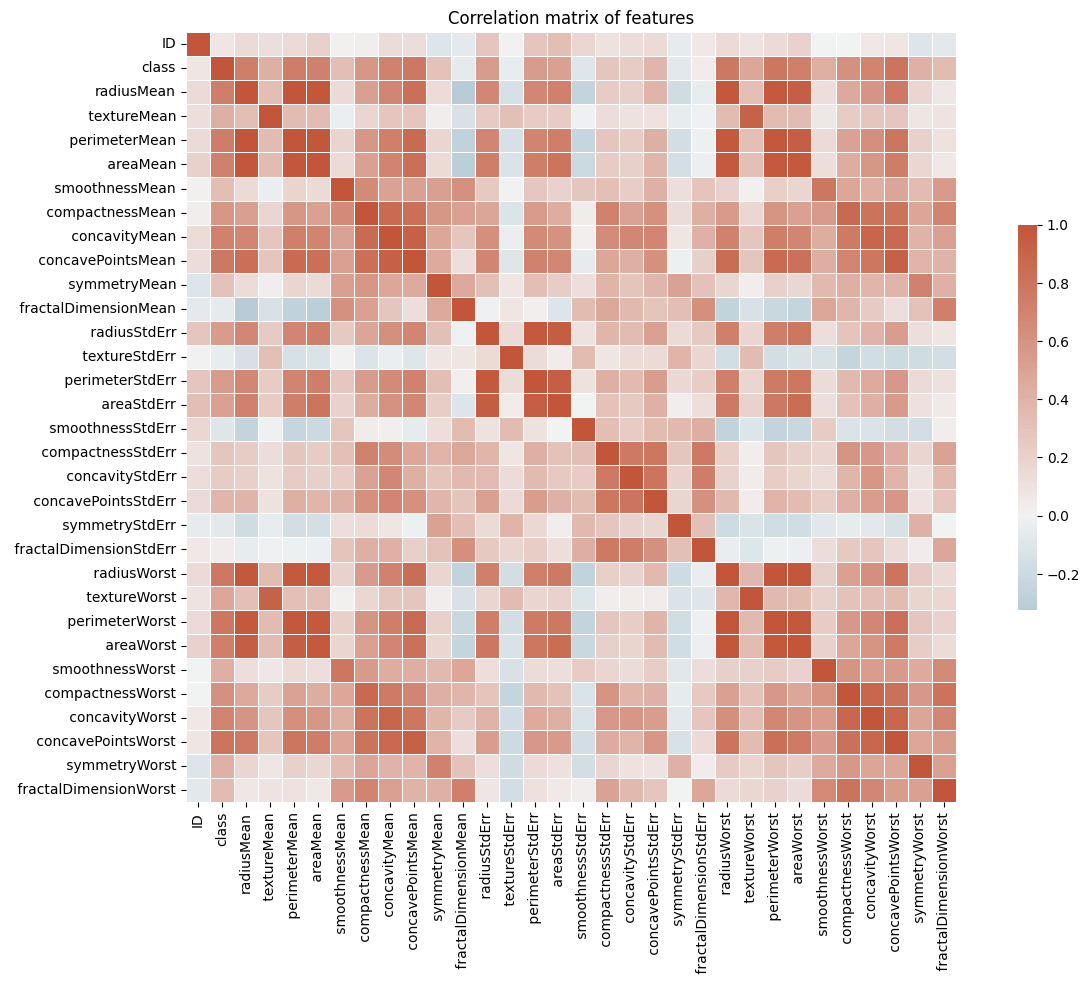

In [ ]:
plt.figure(figsize=(16, 10))
corr = df[2:].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr,cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix of features')
plt.show()

In [ ]:

#creating normalizing scaler
scaler = StandardScaler()
X = df.drop(columns=['class', 'ID'])
y = df['class']


In [ ]:
def fit_rf(X, y):
  n_estimators = [50, 100, 150, 200]
  max_depth = [6, 9, 12, 15]
  min_samples_split = [2, 4, 8, 12]
  number_of_splits = 5

  best_params = {}
  best_mean_score = 0.0
  accuracies = []

  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  for estimators in n_estimators:
    for depth in max_depth:
      for samples_split in min_samples_split:
        
        clf = RandomForestClassifier(n_estimators=estimators, 
                                  max_depth=depth, 
                                  min_samples_split=samples_split)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        #calculating results
        balanced_score = balanced_accuracy_score(y_test, y_pred)
        score = clf.score(X_test, y_test)
        mean_score = (balanced_score + score) / 2
        accuracies.append(mean_score)
        #saving best hyperparameters and results
        if  mean_score > best_mean_score:
          best_mean_score = mean_score
          best_params['n_estimators'] = estimators
          best_params['max_depth'] = depth
          best_params['min_samples_split'] = samples_split
          conf_matrix = confusion_matrix(y_test, y_pred)
          classification_rep = classification_report(y_test, y_pred, target_names=['negative', 'positive'])

  print(f'Mean of accuracy and balanced accuracy on the test data: {best_mean_score* 100:.2f}%') 
  print(f'Best hyperparameters found in the process: {best_params}')
  print(f'classification report:\n {classification_rep}')
  return conf_matrix, accuracies, best_params

In [ ]:
#confusion matrix and accuracy with respect to hyperparameters setting
def plot_results(conf_matrix, accuracies, hyperparameter=None):
  plt.figure(figsize=(12,6))
  tmp_df = pd.DataFrame(conf_matrix, index = ['negative', 'positive'],
                    columns = ['negative', 'positive'])
  plt.subplot(1,2,1)
  sns.heatmap(tmp_df / np.sum(conf_matrix), annot=True, cmap=cmap, fmt='.2%')
  plt.title('confusion matrix')

  #When using KNN, it plots accuracy with respect to n_neighbors
  #else only accuracies with respect to current iteration of search
  if hyperparameter is not None:
    plt.plot(hyperparameter, accuracies)
  if len(accuracies) <= 1:
    print('Not enough accuracy to plot the results')
  else:
    plt.subplot(1,2,2)
    plt.plot(accuracies)
    plt.title('Mean accuracy in each hyperparameters settings')
    plt.ylabel('Accuracy')
    plt.show()

Mean of accuracy and balanced accuracy on the test data: 96.89%
Best hyperparameters found in the process: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 4}
classification report:
               precision    recall  f1-score   support

    negative       1.00      0.95      0.97        37
    positive       0.91      1.00      0.95        20

    accuracy                           0.96        57
   macro avg       0.95      0.97      0.96        57
weighted avg       0.97      0.96      0.97        57

f1-score obtained using cross validation on best hyperparameters setting
0.899789131620769


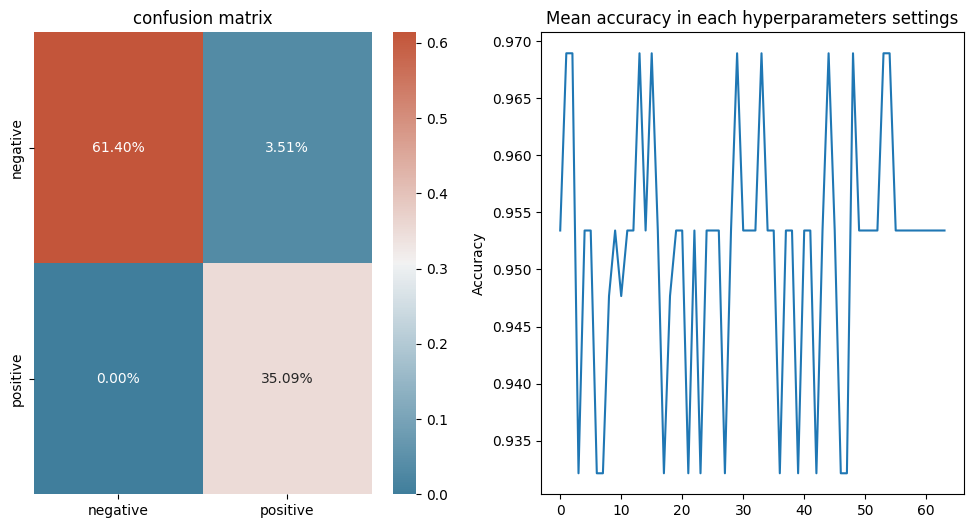

In [ ]:
conf_matrix, accuracies, best_params = fit_rf(X, y)

clf = RandomForestClassifier(**best_params)
score = cross_validate(clf, X, y, cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies)

In [ ]:
#fits model and return results
from sklearn.naive_bayes import GaussianNB
def fit_NB(X, y):
  accuracies = []
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  clf = GaussianNB()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  balanced_score = balanced_accuracy_score(y_test, y_pred)
  score = clf.score(X_test, y_test)
  mean_score = (balanced_score + score) / 2
  accuracies.append(mean_score)
  conf_matrix = confusion_matrix(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred, target_names=['negative', 'positive'])
  print(f'Mean of accuracy and balanced accuracy on the test data: {mean_score* 100:.2f}%') 
  print(f'classification report:\n {classification_rep}')
  return conf_matrix, accuracies

Mean of accuracy and balanced accuracy on the test data: 88.59%
classification report:
               precision    recall  f1-score   support

    negative       0.89      0.94      0.92        36
    positive       0.89      0.81      0.85        21

    accuracy                           0.89        57
   macro avg       0.89      0.88      0.88        57
weighted avg       0.89      0.89      0.89        57

f1-score obtained using cross validation on best hyperparameters setting
0.9227698286521816
Not enough accuracy to plot the results


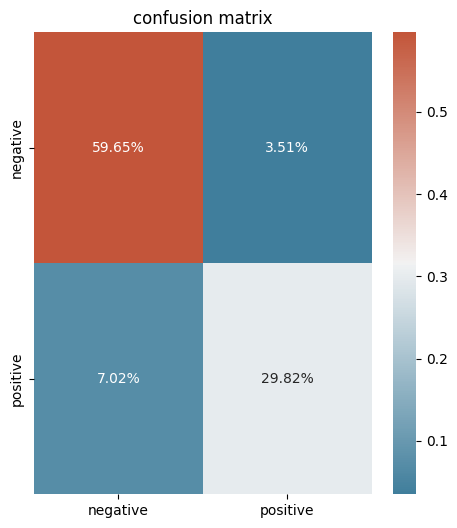

In [ ]:
#using not transformed data
start_time_NB = time.time()
conf_matrix, accuracies = fit_NB(X, y)
end_time_NB = time.time()
clf = GaussianNB()
score = cross_validate(clf, X_train, y_train, cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def fit_KNN(X, y):
  n_neighbors = np.arange(2, 20, 2)
  best_params = {}
  best_mean_score = 0.0
  mean_score = 0.0
  accuracies = []
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

  for neighbors in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors = neighbors)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    balanced_score = balanced_accuracy_score(y_test, y_pred)
    score = clf.score(X_test, y_test)
    mean_score = (balanced_score + score) / 2
    accuracies.append(mean_score)
    if  mean_score > best_mean_score:
      best_mean_score = mean_score
      best_params['neighbors'] = neighbors
      conf_matrix = confusion_matrix(y_test, y_pred)
      classification_rep = classification_report(y_test, y_pred, target_names=['negative', 'positive'])
  print(f'Mean of accuracy and balanced accuracy on the test data: {best_mean_score* 100:.2f}%') 
  print(f'classification report:\n {classification_rep}')
  return conf_matrix, accuracies, n_neighbors

Mean of accuracy and balanced accuracy on the test data: 87.59%
classification report:
               precision    recall  f1-score   support

    negative       0.86      1.00      0.92        36
    positive       1.00      0.71      0.83        21

    accuracy                           0.89        57
   macro avg       0.93      0.86      0.88        57
weighted avg       0.91      0.89      0.89        57

f1-score obtained using cross validation on best hyperparameters setting
0.8534247481230792


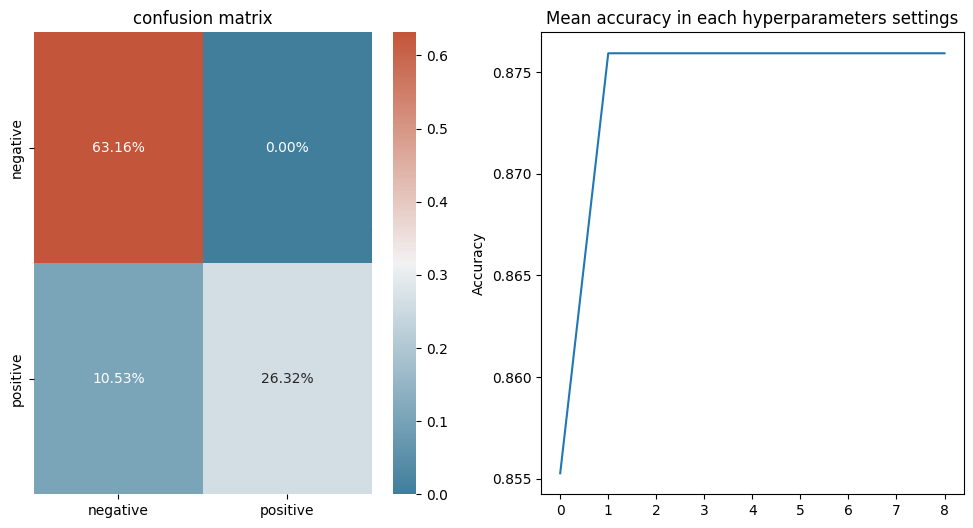

In [ ]:
start_time_KNN = time.time()
conf_matrix, accuracies, n_neighbors = fit_KNN(X, y)
end_time_KNN = time.time()
n_neighbors_cv = n_neighbors[np.argmax(accuracies)]
clf = KNeighborsClassifier(n_neighbors=n_neighbors_cv)
score = cross_validate(clf,X,y,cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies, n_neighbors)

### Summary



*   this dataset is much more to hyperparameters settings, as changes to these settings do not significantly affect the results.
*  cross validation achived simillar results to holdout split, even thought the data for cross validation was not normalized
* each model achived simillar accuracy, with random forest achiving the highest

